# Contrails detection model in timeseries dataset

In [1]:
import os 
import sys 
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')
# Pytorch module 
import torch
import torchvision
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torch.utils.tensorboard import SummaryWriter

import pytorch_lightning as pl

import random
from typing import Any, Mapping
from time import gmtime, strftime

# set working directory
os.chdir('/home/jovyan/contrails/contrails_detection/')

# Project Module
import config
import src.utils as utils
from src.dataset import ContrailsDataset, ContrailsDatasetSeqs
from src.model import BaseUnet, SegmentLightning, AttentionUNet, UNetPlus, SegmentLightningTS
from src.train import Trainer
from src.trainer_lgt import TrainerLightning

## Tensorboard Modules
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping

# Memory management
def clear_torch_cache():
    torch.cuda.empty_cache()
    print("Cleared PyTorch GPU cache.")

# Run the function to clear GPU cache
clear_torch_cache()

!nvidia-smi

Cleared PyTorch GPU cache.
Sat Aug 17 12:10:12 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.116.03   Driver Version: 525.116.03   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA RTX A4000    Off  | 00000000:03:00.0 Off |                  Off |
| 30%   38C    P0    32W / 140W |      0MiB / 16376MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                             

In [2]:
## Load file from csv split into train/test
from sklearn.model_selection import train_test_split
df = pd.read_csv(config.CSV_TRAIN_REC, index_col=0)
train_df, valid_df = train_test_split(df[df.Class.isin([0,1])], test_size = .2, random_state=42)
train_df.head()

,Image_ID,Class
16081,8975896718947475053,0
17494,2887461863286016746,0
15040,1323985642378913441,1
7528,8578962451401293377,0
18488,1733973341297589475,1


In [12]:
torch.manual_seed(44)
transform = transforms.Compose([
    # Add your desired transformations here
    #transforms.ToTensor(),
    transforms.Lambda(lambda x: x/256.0),
    transforms.Lambda(utils.get_rgb),
    #transforms.Lambda(lambda x: utils.get_rgb(x)),
    #transforms.Lambda(lambda x: utils.compute_TDi_ashrgb(x, -5)),
                      ])


train_dataset = ContrailsDatasetSeqs(dataframe=train_df.head(4000),
                                 root_dir=config.DATA_DIR+'train',
                                 transform=transform,
                                )

## Data Loaders
train_dataloader = DataLoader(train_dataset,
                              batch_size=4,
                              shuffle=True,
                              num_workers=config.WORKERS,
                              pin_memory=True,
                              prefetch_factor=config.WORKERS,
                             )

## Validation Dataloader 
valid_dataset = ContrailsDatasetSeqs(dataframe=valid_df.head(1000),
                                 root_dir=config.DATA_DIR+'train',
                                 transform=transform,
                                )

valid_dataloader = DataLoader(valid_dataset,
                              batch_size=4,
                              shuffle=False,
                              num_workers=config.WORKERS,
                              prefetch_factor=config.WORKERS
                             )

In [13]:
%%time
t_image, t_mask = next(iter(train_dataloader))
print(len(train_dataloader))
t_image.shape, t_mask.shape

1000
CPU times: user 52 ms, sys: 3.95 s, total: 4 s
Wall time: 4.51 s


(torch.Size([4, 3, 8, 256, 256]), torch.Size([4, 1, 256, 256]))

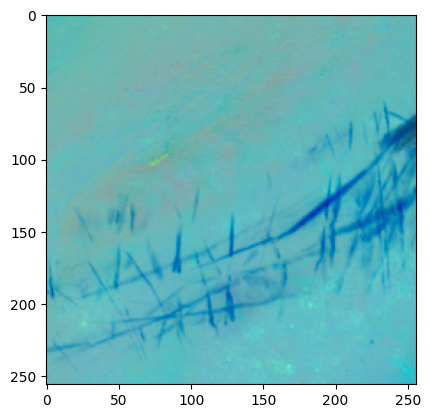

In [26]:
plt.imshow(t_image[6][:, 0, :, :].permute(1,2,0))

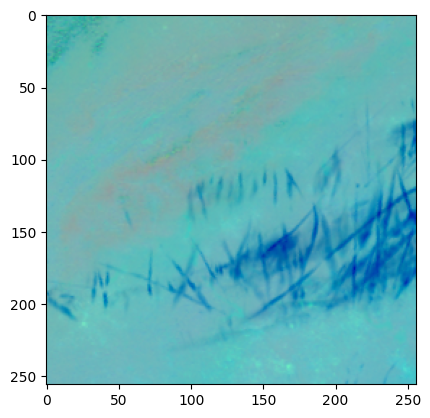

In [25]:
plt.imshow(t_image[6][:, 7, :, :].permute(1,2,0))

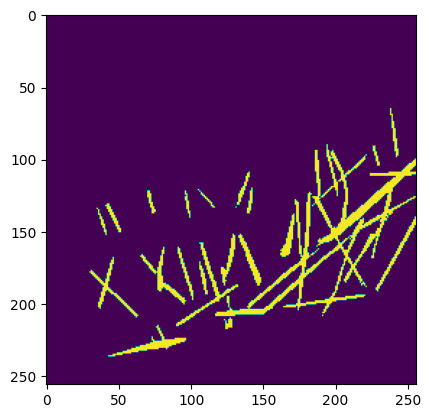

In [19]:
plt.imshow(t_mask[6, 0, :, :])

#### Animation 

In [10]:
import torch
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter

def visualize_dataset(images, masks, save_path=None):
    fig, ax = plt.subplots(figsize=(8, 8))
    def update(frame):
        ax.clear()
        batch_idx = frame // 9
        image_idx = frame % 9
        image = images[batch_idx, image_idx,0].cpu().numpy()
        mask = masks[batch_idx, 0].cpu().numpy()
        ax.imshow(image)  # Display as grayscale
        ax.imshow(mask, alpha=0.3, cmap='jet')
        ax.set_title(f"Batch {batch_idx + 1}, Image {image_idx + 1}")
        ax.axis('off')
    anim = FuncAnimation(fig, update, frames=4*9, interval=500, repeat=True)
    # Save the animation if a save path is provided
    if save_path:
        anim.save(save_path, writer=PillowWriter(fps=2))
    # Display the animation in the notebook
    from IPython.display import HTML
    plt.close(fig)
    return HTML(anim.to_jshtml())


In [12]:
## Visualize 
#anim = visualize_dataset(t_image, t_mask, save_path='dataset_animation.gif')
#display(anim)

## Model Building

### 3D U-Net++

In [30]:
import torch.nn as nn
import torch.nn.functional as F

class DoubleConv3D(nn.Module):
    """(Conv3D -> BN -> ReLU) * 2"""
    def __init__(self, in_channels, out_channels):
        super(DoubleConv3D, self).__init__()
        self.double_conv = nn.Sequential(
            nn.Conv3d(in_channels, out_channels, kernel_size=2, padding=1),
            nn.BatchNorm3d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv3d(out_channels, out_channels, kernel_size=2, padding=1),
            nn.BatchNorm3d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

class UNet3DPlusPlus(nn.Module):
    def __init__(self, in_channels=3, out_channels=1, features=[64, 128, 256, 512]):
        super(UNet3DPlusPlus, self).__init__()
        self.ups = nn.ModuleList()
        self.downs = nn.ModuleList()
        
        # Pooling layer with stride of 1 in the depth dimension to prevent collapse
        self.pool = nn.MaxPool3d(kernel_size=(2, 2, 2), stride=(1, 2, 2), padding=(0, 0, 0))

        # Down part of U-Net++
        for feature in features:
            self.downs.append(DoubleConv3D(in_channels, feature))
            in_channels = feature

        # Up part of U-Net++
        for feature in reversed(features):
            self.ups.append(
                nn.ConvTranspose3d(
                    feature * 2, feature, kernel_size=2, stride=2,
                )
            )
            self.ups.append(DoubleConv3D(feature * 2, feature))

        self.bottleneck = DoubleConv3D(features[-1], features[-1] * 2)
        self.final_conv = nn.Conv3d(features[0], out_channels, kernel_size=1)

    def forward(self, x):
        skip_connections = []

        for down in self.downs:
            x = down(x)
            skip_connections.append(x)
            x = self.pool(x)

        x = self.bottleneck(x)
        skip_connections = skip_connections[::-1]

        for idx in range(0, len(self.ups), 2):
            x = self.ups[idx](x)
            skip_connection = skip_connections[idx // 2]

            if x.shape != skip_connection.shape:
                x = F.interpolate(x, size=skip_connection.shape[2:])

            concat_skip = torch.cat((skip_connection, x), dim=1)
            x = self.ups[idx + 1](concat_skip)

        return self.final_conv(x)

In [37]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class DoubleConv3D(nn.Module):
    """(Conv3D -> BN -> ReLU) * 2"""
    def __init__(self, in_channels, out_channels):
        super(DoubleConv3D, self).__init__()
        self.double_conv = nn.Sequential(
            nn.Conv3d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm3d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv3d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm3d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

class UNet3DPlusPlus(nn.Module):
    def __init__(self, in_channels=3, out_channels=1, features=[64, 128, 256, 512]):
        super(UNet3DPlusPlus, self).__init__()
        self.ups = nn.ModuleList()
        self.downs = nn.ModuleList()
        
        # Pooling layer with stride of 1 in the depth dimension to prevent collapse
        self.pool = nn.MaxPool3d(kernel_size=(2, 2, 2), stride=(1, 2, 2), padding=(0, 0, 0))

        # Down part of U-Net++
        for feature in features:
            self.downs.append(DoubleConv3D(in_channels, feature))
            in_channels = feature

        # Up part of U-Net++
        for feature in reversed(features):
            self.ups.append(
                nn.ConvTranspose3d(
                    feature * 2, feature, kernel_size=2, stride=(1, 2, 2),
                )
            )
            self.ups.append(DoubleConv3D(feature * 2, feature))

        self.bottleneck = DoubleConv3D(features[-1], features[-1] * 2)
        
        # Final 2D convolution to collapse the depth dimension
        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)

    def forward(self, x):
        skip_connections = []

        for down in self.downs:
            x = down(x)
            skip_connections.append(x)
            x = self.pool(x)

        x = self.bottleneck(x)
        skip_connections = skip_connections[::-1]

        for idx in range(0, len(self.ups), 2):
            x = self.ups[idx](x)
            skip_connection = skip_connections[idx // 2]

            if x.shape != skip_connection.shape:
                x = F.interpolate(x, size=skip_connection.shape[2:])

            concat_skip = torch.cat((skip_connection, x), dim=1)
            x = self.ups[idx + 1](concat_skip)

        # Collapse the depth dimension and apply the final 2D convolution
        x = x.mean(dim=2)  # Average over the depth dimension
        return self.final_conv(x)

In [38]:
t_image.shape

torch.Size([4, 3, 8, 256, 256])

In [39]:
unet3d_model = UNet3DPlusPlus(in_channels=3, out_channels=1)

In [40]:
output = unet3d_model(t_image)

In [41]:
output.shape

torch.Size([4, 1, 256, 256])

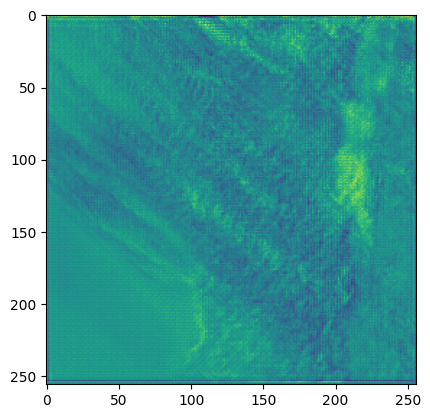

In [45]:
plt.imshow(output[2, 0,:, :].detach().numpy())

In [46]:
main_model = unet3d_model.to(config.DEVICE)

_expr_name = "3DUNetPlus_TL"
tb_path = "tb_log/O3_TS"
logger = pl.loggers.TensorBoardLogger(tb_path, name=_expr_name)
logger

In [50]:
# Criterion
criterion = utils.TverskyLoss()

# Gradient clipping
torch.nn.utils.clip_grad_norm_(main_model.parameters(), max_norm=1.0)

# Scheduler
scheduler_name = 'ReduceLROnPlateau'
scheduler_params = {'factor': 0.1, 'patience': 3, 'min_lr': 1e-6}

# Training Model
lgt_O3model = SegmentLightningTS(
            model=main_model,
            criterion=criterion,
            learning_rate=1e-5,
            scheduler_name=scheduler_name,
            scheduler_params=scheduler_params,
            train_dataset=train_dataset,
            val_dataset=valid_dataset,
            batch_size=4
        )

In [51]:
early_stop_callback = pl.callbacks.EarlyStopping(monitor='val_loss', patience=10)
checkpoint_callback = pl.callbacks.ModelCheckpoint(
            dirpath=f'./model_checkpoints/OBJ3/' + _expr_name,
            monitor="val_loss",
            save_last=True,
            save_top_k=5
        )

torch.cuda.empty_cache()

In [52]:
# Trainer
trainer = pl.Trainer(
            max_epochs=30,
            logger=logger,
            precision=config.PRECISION,
            accelerator=config.ACCELERATOR,
            devices=[0],
            min_epochs=1,
            callbacks=[checkpoint_callback, early_stop_callback],
        )
# Start training
trainer.fit(lgt_O3model)

Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type           | Params
----------------------------------------------------
0 | model            | UNet3DPlusPlus | 90.3 M
1 | criterion        | TverskyLoss    | 0     
2 | dice_coefficient | Dice           | 0     
----------------------------------------------------
90.3 M    Trainable params
0         Non-trainable params
90.3 M    Total params
180.616   Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=30` reached.


### LSTM + UNet++

In [24]:
import torch
import torch.nn as nn

class CNNRNNModel(nn.Module):
    def __init__(self, num_frames=8, in_channels=3, out_channels=1, hidden_dim=256, rnn_type='LSTM'):
        super(CNNRNNModel, self).__init__()
        self.num_frames = num_frames
        self.hidden_dim = hidden_dim  # Store hidden_dim as a class attribute
        self.unet = UNetPlus(in_channels=in_channels, out_channels=hidden_dim)
        
        if rnn_type == 'LSTM':
            self.rnn = nn.LSTM(hidden_dim, hidden_dim, batch_first=True)
        elif rnn_type == 'GRU':
            self.rnn = nn.GRU(hidden_dim, hidden_dim, batch_first=True)
        else:
            raise ValueError("rnn_type must be 'LSTM' or 'GRU'")
        
        self.fc = nn.Conv2d(hidden_dim, out_channels, kernel_size=1)

    def forward(self, x):
        batch_size, channels, num_frames, height, width = x.size()
        rnn_input = []

        for t in range(num_frames):
            frame = x[:, :, t, :, :]  # Extract the frame from the sequence
            cnn_out = self.unet(frame)  # Shape: (batch_size, hidden_dim, H, W)
            cnn_out = cnn_out.view(batch_size, self.hidden_dim, -1)  # Flatten spatial dimensions
            cnn_out = cnn_out.mean(dim=-1)  # Reduce H*W to a single dimension by averaging
            rnn_input.append(cnn_out)

        rnn_input = torch.stack(rnn_input, dim=1)  # Shape: (batch_size, num_frames, hidden_dim)
        rnn_out, _ = self.rnn(rnn_input)  # Shape: (batch_size, num_frames, hidden_dim)
        rnn_out = rnn_out[:, -1, :]  # Take the last time step, shape: (batch_size, hidden_dim)
        rnn_out = rnn_out.view(batch_size, self.hidden_dim, 1, 1)  # Reshape to (batch_size, hidden_dim, 1, 1)

        rnn_out = rnn_out.expand(-1, -1, height, width)  # Expand to match spatial dimensions

        output = self.fc(rnn_out)  # Shape: (batch_size, out_channels, H, W)
        return output


In [25]:
t_image.shape

torch.Size([4, 3, 8, 256, 256])

In [26]:
hd_model = CNNRNNModel(num_frames=8, in_channels=3, out_channels=1, hidden_dim=256, rnn_type='LSTM')

In [27]:
hd_pred = hd_model(t_image)

In [28]:
hd_pred.shape

torch.Size([4, 1, 256, 256])

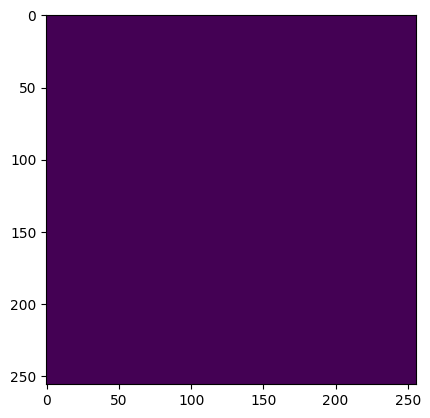

In [29]:
plt.imshow(hd_pred[1, 0, :, :].detach().numpy())

#### Training

In [76]:
import pytorch_lightning as pl
import torchvision
from torchmetrics.classification import  Dice

class SegmentLightning(pl.LightningModule):
    def __init__(self, model, criterion, learning_rate, scheduler_name, scheduler_params, train_dataset, val_dataset, batch_size):
        super(SegmentLightning, self).__init__()
        self.model = model
        self.criterion = criterion
        self.learning_rate = learning_rate
        self.scheduler_name = scheduler_name
        self.scheduler_params = scheduler_params
        self.train_dataset = train_dataset
        self.val_dataset = val_dataset
        self.batch_size = batch_size
        self.dice_coefficient = Dice()

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        data, targets = batch
        outputs = self.model(data)
        loss = self.criterion(outputs, targets)
        dice_coefficient = self.dice_coefficient(outputs, targets.to(torch.uint8))
        self.log('train_loss', loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        self.log('train_dice', dice_coefficient, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        
        return loss

    def validation_step(self, batch, batch_idx):
        data, targets = batch
        outputs = self.model(data)
        loss = self.criterion(outputs, targets)
        dice_coefficient = self.dice_coefficient(outputs, targets.to(torch.uint8))
        self.log('val_loss', loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        self.log('val_dice', dice_coefficient, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, **self.scheduler_params)
        return {
            'optimizer': optimizer,
            'lr_scheduler': {
                'scheduler': scheduler,
                'monitor': 'val_loss',
            }
        }

    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=True, num_workers=4, pin_memory=True)

    def val_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=self.batch_size, shuffle=False, num_workers=4, pin_memory=True)


In [26]:
# Define model, criterion, and other settings
IN_CHNL = 3
OUT_CHNL = 1
hidden_dim = 256
learning_rate = 1e-5
features = [64, 128, 256, 512]

# Initialize the model
main_model = CNNRNNModel(num_frames=8, in_channels=IN_CHNL, out_channels=OUT_CHNL, hidden_dim=hidden_dim, rnn_type='LSTM').to(config.DEVICE)


In [27]:
# Criterion
criterion = nn.BCEWithLogitsLoss()
# Scheduler
scheduler_name = 'ReduceLROnPlateau'
scheduler_params = {'factor': 0.1, 'patience': 3, 'min_lr': 1e-6}

# Training Model
lgt_O3model = SegmentLightning(
    model=main_model,
    criterion=criterion,
    learning_rate=learning_rate,
    scheduler_name=scheduler_name,
    scheduler_params=scheduler_params,
    train_dataset=train_dataset,
    val_dataset=valid_dataset,
    batch_size=4
)

# Callbacks
early_stop_callback = pl.callbacks.EarlyStopping(monitor='val_loss', patience=10)
checkpoint_callback = pl.callbacks.ModelCheckpoint(
    dirpath=f'./model_checkpoints/OBJ3/3DUNetPlus',
    monitor="val_loss",
    save_last=True,
    save_top_k=5
)

In [ ]:
# TensorBoard logger
logger = pl.loggers.TensorBoardLogger("tb_log/O3_TS", name="LSTMUNetPlus")

# Trainer
trainer = pl.Trainer(
    max_epochs=30,
    logger=logger,
    precision=16,  # Or whatever precision setting you have
    accelerator='gpu',  # Use 'gpu' for CUDA
    devices=[0],  # Assuming using a single GPU
    callbacks=[checkpoint_callback, early_stop_callback],
)

# Start training
trainer.fit(lgt_O3model)

Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: tb_log/O3_TS/LSTMUNetPlus
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type              | Params
-------------------------------------------------------
0 | model            | CNNRNNModel       | 8.3 M 
1 | criterion        | BCEWithLogitsLoss | 0     
2 | dice_coefficient | Dice              | 0     
-------------------------------------------------------
8.3 M     Trainable params
0         Non-trainable params
8.3 M     Total params
16.602    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

### STransform with Unet

In [66]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from einops import rearrange

# Keep the PatchEmbedding, TimeSformerBlock, and TimeSformer classes as they were

class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.conv(x)

class UNetPlusTimeSformer(nn.Module):
    def __init__(self, in_channels=3, out_channels=1, num_frames=8, img_size=256, patch_size=16, embed_dim=768, num_heads=12, num_layers=12):
        super(UNetPlusTimeSformer, self).__init__()
        
        self.embed_dim = embed_dim
        self.patch_size = patch_size
        self.img_size = img_size
        self.num_frames = num_frames
        
        # TimeSformer encoder
        self.encoder = TimeSformer(in_channels, patch_size, embed_dim, num_layers, num_heads, num_frames, img_size)
        
        # UNet decoder
        self.decoder_channels = [embed_dim, embed_dim//2, embed_dim//4, embed_dim//8]
        
        self.down_convs = nn.ModuleList()
        self.up_convs = nn.ModuleList()
        self.up_trans = nn.ModuleList()
        
        # Down part of UNet
        self.down_convs.append(DoubleConv(embed_dim, self.decoder_channels[0]))
        for i in range(1, len(self.decoder_channels)):
            self.down_convs.append(DoubleConv(self.decoder_channels[i-1], self.decoder_channels[i]))
        
        # Up part of UNet
        for i in range(len(self.decoder_channels)-1, 0, -1):
            self.up_trans.append(nn.ConvTranspose2d(self.decoder_channels[i], self.decoder_channels[i-1], kernel_size=2, stride=2))
            self.up_convs.append(DoubleConv(self.decoder_channels[i-1]*2, self.decoder_channels[i-1]))
        
        self.final_conv = nn.Conv2d(self.decoder_channels[0], out_channels, kernel_size=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        batch_size, channels, seq_len, height, width = x.size()

        # Pass the input through the TimeSformer encoder
        encoded_features = self.encoder(x)  # Shape: (batch_size, num_patches * seq_len, embed_dim)
        
        # Reshape encoded features
        h_patches = height // self.patch_size
        w_patches = width // self.patch_size
        encoded_features = encoded_features.view(batch_size, seq_len, h_patches, w_patches, self.embed_dim)
        encoded_features = encoded_features.permute(0, 4, 1, 2, 3).contiguous()
        encoded_features = encoded_features.view(batch_size, self.embed_dim, seq_len * h_patches, w_patches)

        # UNet decoder
        x = encoded_features
        skip_connections = []

        for down_conv in self.down_convs[:-1]:
            x = down_conv(x)
            skip_connections.append(x)
            x = self.pool(x)

        x = self.down_convs[-1](x)

        skip_connections = skip_connections[::-1]

        for i, (up_trans, up_conv) in enumerate(zip(self.up_trans, self.up_convs)):
            x = up_trans(x)
            skip = skip_connections[i]
            
            if x.shape != skip.shape:
                x = F.interpolate(x, size=skip.shape[2:])
            
            x = torch.cat([skip, x], dim=1)
            x = up_conv(x)

        # Final upsampling to match the original image size
        x = F.interpolate(x, size=(height, width), mode='bilinear', align_corners=False)
        return self.final_conv(x)

In [67]:
# Example usage
model = UNetPlusTimeSformer(in_channels=3, out_channels=1, num_frames=8, img_size=256, patch_size=16, embed_dim=768, num_heads=12, num_layers=12)
#t_image = torch.randn(4, 3, 8, 256, 256)  # Example input
output = model(t_image)
print(output.shape)

torch.Size([4, 1, 256, 256])


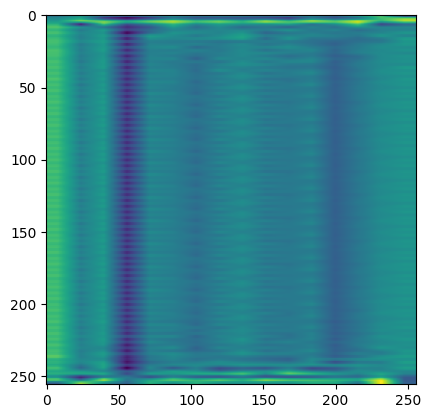

In [72]:
plt.imshow(output[3,0,:,:].detach().numpy())

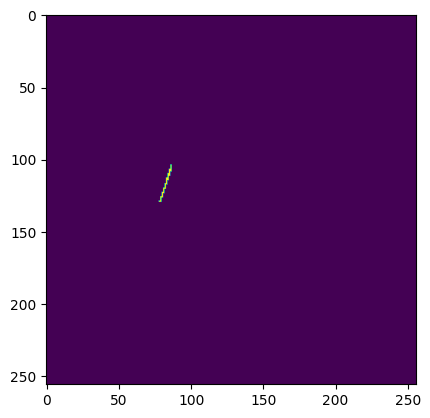

In [69]:
plt.imshow(t_mask[0,0,:,:])

In [77]:
# Criterion
criterion = nn.BCEWithLogitsLoss()
# Scheduler
scheduler_name = 'ReduceLROnPlateau'
scheduler_params = {'factor': 0.1, 'patience': 3, 'min_lr': 1e-6}

# Training Model
lgt_O3model = SegmentLightning(
    model=model,
    criterion=criterion,
    learning_rate=1e-4,
    scheduler_name=scheduler_name,
    scheduler_params=scheduler_params,
    train_dataset=train_dataset,
    val_dataset=valid_dataset,
    batch_size=4
)

# Callbacks
early_stop_callback = pl.callbacks.EarlyStopping(monitor='val_loss', patience=10)
checkpoint_callback = pl.callbacks.ModelCheckpoint(
    dirpath=f'./model_checkpoints/OBJ3/TSformUNet',
    monitor="val_loss",
    save_last=True,
    save_top_k=5
)

In [ ]:
# TensorBoard logger
logger = pl.loggers.TensorBoardLogger("tb_log/O3_TS", name="TSformUNet")

# Trainer
trainer = pl.Trainer(
    max_epochs=30,
    logger=logger,
    precision=16,  # Or whatever precision setting you have
    accelerator='gpu',  # Use 'gpu' for CUDA
    devices=[0],  # Assuming using a single GPU
    callbacks=[checkpoint_callback, early_stop_callback],
)

# Start training
trainer.fit(lgt_O3model)

Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: tb_log/O3_TS/TSformUNet
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                | Params
---------------------------------------------------------
0 | model            | UNetPlusTimeSformer | 152 M 
1 | criterion        | BCEWithLogitsLoss   | 0     
2 | dice_coefficient | Dice                | 0     
---------------------------------------------------------
152 M     Trainable params
0         Non-trainable params
152 M     Total params
304.649   Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

### UNetPlus & LSTM w

In [7]:
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms.functional as TF

class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels, dropout_prob=0.0):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=2, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Dropout2d(dropout_prob),
            nn.Conv2d(out_channels, out_channels, kernel_size=2, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Dropout2d(dropout_prob),
        )

    def forward(self, x):
        return self.conv(x)


class UNetPlusPlus(nn.Module):
    """
    U-Net++ model for semantic segmentation.
    
    Parameters:
        - in_channels (int): Number of input channels (default is 3 for RGB images).
        - out_channels (int): Number of output channels (default is 1 for binary segmentation).
        - features (list): List of features for each level of the U-Net++ (default is [32, 64, 128, 256]).
        - dropout_prob (float): Dropout probability (default is 0.0).
    """
    def __init__(self, in_channels=3, out_channels=1, features=[32, 64, 128, 256], dropout_prob=0.0):
        super(UNetPlusPlus, self).__init__()
        self.ups = nn.ModuleList()
        self.downs = nn.ModuleList()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Down part of U-Net++
        for feature in features:
            self.downs.append(DoubleConv(in_channels, feature))
            in_channels = feature

        # Up part of U-Net++
        for feature in reversed(features):
            self.ups.append(
                nn.ConvTranspose2d(
                    feature*2, feature, kernel_size=2, stride=2,
                )
            )
            self.ups.append(DoubleConv(feature*2, feature))

        self.bottleneck = DoubleConv(features[-1], features[-1]*2)
        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)

    def forward(self, x):
        """
        Forward pass of the U-Net++ model.
        
        Parameters:
            - x (torch.Tensor): Input tensor.
            
        Returns:
            - torch.Tensor: Output tensor.
        """
        skip_connections = []

        for down in self.downs:
            x = down(x)
            skip_connections.append(x)
            x = self.pool(x)

        x = self.bottleneck(x)
        skip_connections = skip_connections[::-1]

        for idx in range(0, len(self.ups), 2):
            x = self.ups[idx](x)
            skip_connection = skip_connections[idx//2]

            if x.shape != skip_connection.shape:
                x = TF.resize(x, size=skip_connection.shape[2:])

            concat_skip = torch.cat((skip_connection, x), dim=1)
            x = self.ups[idx+1](concat_skip)

        return self.final_conv(x)

In [8]:
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms.functional as TF

class UNetPlusLSTM(nn.Module):
    def __init__(self, in_channels=3, out_channels=1, features=[32, 64, 128, 256], lstm_hidden_size=256, dropout_prob=0.0):
        super(UNetPlusLSTM, self).__init__()
        self.unet = UNetPlusPlus(in_channels, features[-1], features, dropout_prob)
        
        # Calculate the correct input size for LSTM
        with torch.no_grad():
            dummy_input = torch.zeros(1, in_channels, 256, 256)
            dummy_output = self.unet(dummy_input)
        self.lstm_input_size = dummy_output.numel()
        
        self.lstm = nn.LSTM(self.lstm_input_size, lstm_hidden_size, batch_first=True)
        self.fc = nn.Linear(lstm_hidden_size, 256 * 256)

    def forward(self, x):
        batch_size, channels, seq_len, height, width = x.shape
        
        # Initialize a tensor to hold LSTM inputs
        lstm_input = torch.zeros((batch_size, seq_len, self.lstm_input_size)).to(x.device)
        
        for i in range(seq_len):
            # Extract the ith sequence from the batch
            seq_input = x[:, :, i, :, :]
            
            # Pass through U-Net++ to get the features
            features = self.unet(seq_input)
            
            # Flatten the features
            features = features.view(batch_size, -1)
            
            # Store the features for the LSTM input
            lstm_input[:, i, :] = features
        
        # Pass the sequential features through LSTM
        lstm_out, _ = self.lstm(lstm_input)
        
        # Take the output from the last LSTM step
        lstm_out = lstm_out[:, -1, :]
        
        # Pass through the fully connected layer to get the final output
        output = self.fc(lstm_out)
        output = output.view(batch_size, 1, 256, 256)
        
        return output

In [9]:
t_image.shape

torch.Size([2, 3, 8, 256, 256])

In [10]:
model = UNetPlusLSTM(in_channels=3, out_channels=1, features=[32, 64, 128, 256], lstm_hidden_size=256, dropout_prob=0.0)

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

OutOfMemoryError: CUDA out of memory. Tried to allocate 66.02 GiB (GPU 0; 15.73 GiB total capacity; 14.74 MiB already allocated; 15.04 GiB free; 26.00 MiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

#### training

In [ ]:
# Criterion
criterion = utils.TverskyLoss() #nn.BCEWithLogitsLoss()
# Scheduler
scheduler_name = 'ReduceLROnPlateau'
scheduler_params = {'factor': 0.1, 'patience': 3, 'min_lr': 1e-6}

# Training Model
lgt_O3model = SegmentLightningTS(
    model=model.to(config.DEVICE),
    criterion=criterion,
    learning_rate=1e-5,
    scheduler_name=scheduler_name,
    scheduler_params=scheduler_params,
    train_dataset=train_dataset,
    val_dataset=valid_dataset,
    batch_size=4
)

# Callbacks
early_stop_callback = pl.callbacks.EarlyStopping(monitor='val_loss', patience=10)
checkpoint_callback = pl.callbacks.ModelCheckpoint(
    dirpath=f'./model_checkpoints/OBJ3/LSTM_UNet_TL',
    monitor="val_loss",
    save_last=True,
    save_top_k=5
)

In [ ]:
# TensorBoard logger
logger = pl.loggers.TensorBoardLogger("tb_log/O3_TS", name="LSTM_UNet_TL")

# Trainer
trainer = pl.Trainer(
    max_epochs=30,
    logger=logger,
    precision=16,  # Or whatever precision setting you have
    accelerator='gpu',  # Use 'gpu' for CUDA
    devices=[0],  # Assuming using a single GPU
    callbacks=[checkpoint_callback, early_stop_callback],
)

# Start training
trainer.fit(lgt_O3model)